#### **Summary of EDA**

- <span style="color:blue">Process equipment / raw material stability</span>
    - Defect density is very high close to Y direction start point, suggesting unstable or process equipment / raw material or cleaniness issue at the initial stage.
    - Defect density dramatically reduces when Y becomes bigger, then shows intermittent pattern.
- <span style="color:blue">Measurement machine setting consistency issue</span>
    - A small ratio of points are found with different (order level) pixel resolution
    - Maybe operator did not follow the setting in SOP
    - Maybe other settings are also not always consistent, which will affect model prediction accuracy.
- <span style="color:blue">All defects can be roughly classified into 3 types</span>
    1. Clear **pattern on X direction**
        - Include `Z_Scratch`, `K_Scratch`, `Stains` and `Dirtiness`
        - They concentrate on different X locations and show significant difference on other features.
        - Likely they originate from process machine part cleaniness issue.
            - The part contacting raw material was dirty, so generated many defects at initial stage.
            - As the process went on the part was cleaned, so defect count reduce along Y direction.
            - Different location on the part has different type of dirt, so generating different type of defects on product along X direction.
    2. Clear **intermittent pattern on Y direction**
        - Include `Bumps` and `Other_Faults`
        - At initial stage, they co-exist with any of the above type 1 defects
        - When type 1 defects reduce to very low level along Y direction, they start to show intermittent pattern and distribute uniformly along X direction.
        - The cause of these 2 defects are likely due to overall process machine stability, which can be mechanical issue (e.g. vibration), electric issue (e.g. static electric charge), etc.
        - `Bumps` and `Other_Faults` are quite similar on all features, maybe difficult to classify them accurately.
    3. `Pastry`
        - It's characteristics are in between above type 1 and 2 defects.

In [1]:
# setup environment
input_path = './data/'
output_path = './output01/'

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

In [2]:
# load raw data
df_train_raw = pd.read_csv(input_path + 'train.csv') # train dataset
df_test_raw = pd.read_csv(input_path + 'test.csv') # test dataset

df_train_raw.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [3]:
# study train dataset
df0 = df_train_raw.drop(columns=['id']) # drop id
df0.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,128.647380,1459.350747,0.402674,0.596337,76.213122,0.352939,0.409309,0.574520,0.030609,0.614749,0.831652,0.591899,2.473475,1.312667,1.389737,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,14.196976,145.568687,0.490449,0.490644,53.931960,0.318976,0.124143,0.259436,0.047302,0.222391,0.220966,0.482050,0.760575,0.467848,0.405549,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,39.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.317500,0.375750,0.006600,0.451600,0.655200,0.000000,1.949400,1.000000,1.079200,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413500,0.545400,0.009500,0.636400,0.964300,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.656100,0.494600,0.818200,0.019100,0.785700,1.000000,1.000000,2.814900,1.431400,1.707600,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.927500,1.000000,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              19219 non-null  int64  
 1   X_Maximum              19219 non-null  int64  
 2   Y_Minimum              19219 non-null  int64  
 3   Y_Maximum              19219 non-null  int64  
 4   Pixels_Areas           19219 non-null  int64  
 5   X_Perimeter            19219 non-null  int64  
 6   Y_Perimeter            19219 non-null  int64  
 7   Sum_of_Luminosity      19219 non-null  int64  
 8   Minimum_of_Luminosity  19219 non-null  int64  
 9   Maximum_of_Luminosity  19219 non-null  int64  
 10  Length_of_Conveyer     19219 non-null  int64  
 11  TypeOfSteel_A300       19219 non-null  int64  
 12  TypeOfSteel_A400       19219 non-null  int64  
 13  Steel_Plate_Thickness  19219 non-null  int64  
 14  Edges_Index            19219 non-null  float64
 15  Em

#### Overview of raw data

- Shape: 19219 rows, 34 columns (excluding `id`)
    - 27 independent features, 7 dependent features
- All columns are numeric
- No missing value

#### Interpret raw data

- Based on the name of the columns, this dataset is likely measurement data from a surface optical analysis equipment with some properties of the samples.
- The features with dtype `int64` should be machine readings.
- The features with dtype `float64` are likely engineered features calculated from other features.

In [5]:
# verify if the dependent features are one hot encoded defect category
pred_features = df0.columns.to_list()[-7:]
df0['num_defect_types'] = df0[pred_features].apply(lambda x: x.sum(), axis=1)
df0['num_defect_types'].value_counts()

num_defect_types
1    18380
0      818
2       21
Name: count, dtype: int64

- Most rows (18380/19219) are labelled with 1 defect type.
- 818/19219 rows are not labelled with any defect type.
- 21/19219 rows are labelled with 2 defect types.

In [6]:
df0[df0['num_defect_types']==2]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,num_defect_types
634,41,192,1682722,1682891,9927,578,343,1098162,29,141,1402,0,1,40,0.0585,0.4970,0.9408,0.1054,0.2390,0.3925,1.0,3.9968,1.0000,2.2175,0.0592,-0.1071,1.0000,0,0,1,0,0,0,1,2
752,39,194,2134009,2134076,10904,562,360,1130960,32,141,1400,0,1,40,0.0557,0.5917,0.3478,0.1107,0.2672,0.4615,1.0,4.0379,2.1931,2.1761,0.6522,-0.1031,0.4630,0,0,1,0,0,0,1,2
3572,241,360,938265,938349,2027,178,118,241083,38,108,1360,0,1,40,0.2801,0.6670,0.4167,0.0553,0.2352,0.6377,0.0,3.3068,1.8751,1.8808,-0.5833,-0.3705,1.0000,0,0,1,0,0,1,0,2
4416,39,729,498078,498335,13114,976,453,1438454,29,143,1400,0,1,40,0.0586,0.6635,0.9558,0.1250,0.2656,0.4011,1.0,4.1150,2.2529,2.2355,0.0442,-0.0960,1.0000,0,0,1,0,0,0,1,2
4530,39,222,221142,2212144,10166,634,383,1130960,31,141,1400,0,1,40,0.0586,0.4647,0.9855,0.1293,0.2749,0.4355,1.0,4.0072,2.2529,2.2227,0.0145,-0.2199,1.0000,0,0,1,0,0,0,1,2
4664,39,218,7430,7458,21321,758,441,2256472,22,143,1400,0,1,40,0.0557,0.7906,0.9537,0.1280,0.2422,0.4157,0.0,4.3245,2.2529,2.2967,-0.0263,-0.0573,1.0000,0,0,1,0,0,0,1,2
6448,41,192,92878,92896,11211,572,357,1402972,31,141,1402,0,1,40,0.0585,0.5904,0.8871,0.1077,0.2394,0.4033,1.0,4.0520,2.1790,2.2175,0.1129,-0.0948,1.0000,0,0,1,0,0,0,1,2
7589,41,776,844714,844903,11711,822,497,1351903,25,141,1400,0,1,40,0.0557,0.5398,0.7936,0.1605,0.2292,0.3527,1.0,4.0630,2.3522,2.3117,0.2064,-0.0971,1.0000,0,0,1,0,0,0,1,2
8075,41,193,1725027,1725163,10941,639,409,1270726,40,141,1400,0,1,40,0.0557,0.5059,0.9358,0.1091,0.2458,0.4487,1.0,4.0366,2.1847,2.1987,0.0642,-0.1077,1.0000,0,0,1,0,0,0,1,2
8538,39,215,1512277,1512467,13033,709,424,1508093,26,141,1400,0,1,40,0.0605,0.5232,0.9607,0.1298,0.2409,0.4695,1.0,4.1150,2.2577,2.2175,0.0393,-0.0966,1.0000,0,0,1,0,0,0,1,2


- For the rows labelled with 2 defect types, one of them is always `K_Scatch`, the other one is `Other_Faults` most of the time.

In [7]:
# for the ease of EDA, generate DataFrame with single column 'defect_type`
df_eda = df0[df0['num_defect_types']==0].\
            drop(columns=(pred_features + ['num_defect_types'])).\
            reset_index(drop=True)
df_eda['defect_type'] = ['No_defect'] * df_eda.shape[0]

for col in pred_features:
    df_temp = df0[df0[col]==1].\
                drop(columns=(pred_features + ['num_defect_types'])).\
                reset_index(drop=True)
    df_temp['defect_type'] = [col] * df_temp.shape[0]
    df_eda = pd.concat([df_eda, df_temp], axis=0)

df_eda.reset_index(drop=True, inplace=True)
df_eda['defect_type'] = pd.Categorical(df_eda['defect_type'],
                                       categories=(pred_features + ['No_defect']),
                                       ordered=True)

In [8]:
# feature engineer
df_eda['X_Center'] = (df_eda['X_Maximum'] + df_eda['X_Minimum'])/2
df_eda['X_Range'] = df_eda['X_Maximum'] - df_eda['X_Minimum']
df_eda['Y_Center'] = (df_eda['Y_Maximum'] + df_eda['Y_Minimum'])/2
df_eda['Y_Range'] = df_eda['Y_Maximum'] - df_eda['Y_Minimum']
df_eda['Aspect_Ratio'] = df_eda['Y_Perimeter'] / df_eda['X_Perimeter']
df_eda['Mean_Luminosity'] = df_eda['Sum_of_Luminosity'] / (10**df_eda['LogOfAreas'])
df_eda['Delta_Luminosity'] = df_eda['Maximum_of_Luminosity'] - df_eda['Minimum_of_Luminosity']

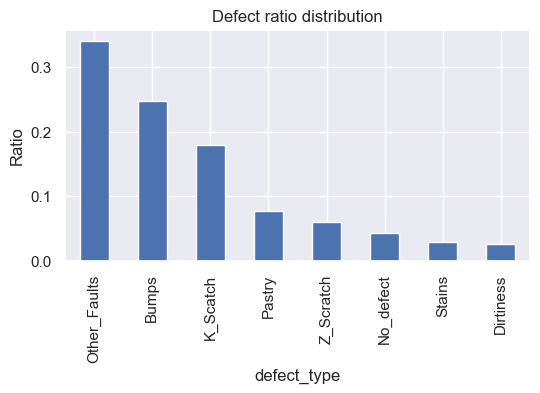

In [9]:
df_eda['defect_type'].value_counts(normalize=True).plot.\
    bar(figsize=(6,3), title='Defect ratio distribution')
plt.ylabel('Ratio')
plt.show()

- Defect type distribution is imbalanced.

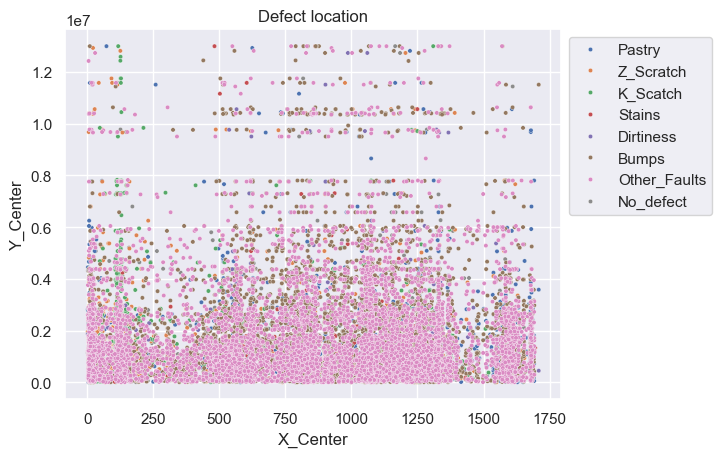

In [10]:
sns.scatterplot(df_eda, x='X_Center', y='Y_Center', hue='defect_type', s=10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Defect location')
plt.show()

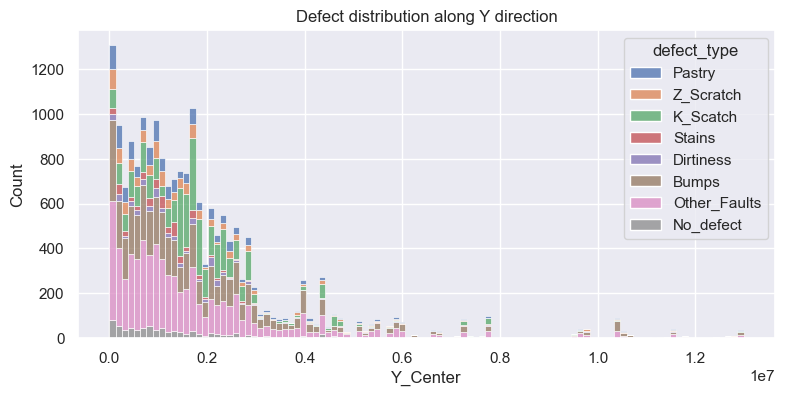

In [11]:
plt.figure(figsize=(9, 4))
sns.histplot(df_eda, x='Y_Center', hue='defect_type', multiple='stack')
plt.title('Defect distribution along Y direction')
plt.show()

- High defect population close to $Y=0$ location.
    - Maybe process is not stable at beginning.
- Less defects at $Y>0.6 \times 10^7$, but showing band patterns.
    - Process is more stable but has intermittent issues.

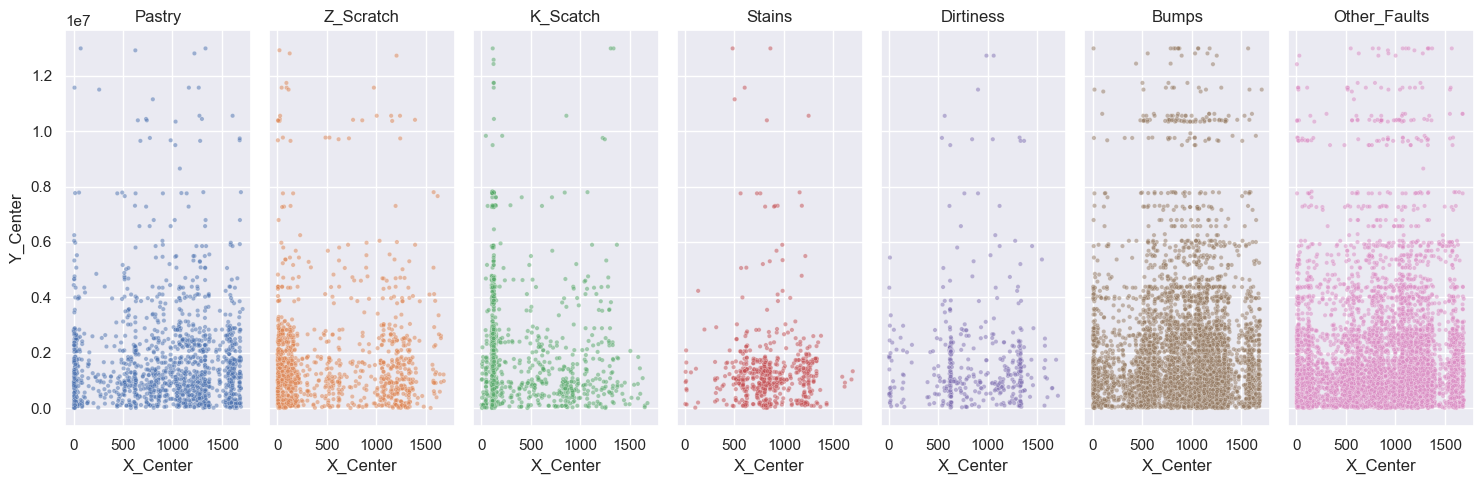

In [12]:
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    sns.scatterplot(df_eda[df_eda['defect_type']==defect],
                    x='X_Center', y='Y_Center', hue='defect_type',
                    ax=axs[i], s=10, alpha=.5)
    axs[i].get_legend().remove()
    axs[i].set_title(defect)
fig.tight_layout()
fig.show()

- `Z_Scratch`, `K_Scratch`, `Stains` and `Dirtiness` show specific X distribution.
    - Maybe each of them are related to specific machine parts.
- `Bumps` and `Other_Faults` show more significant Y direction intermittent pattern.
    - Maybe they are related to process stability (vibration, etc.) or raw material issue.

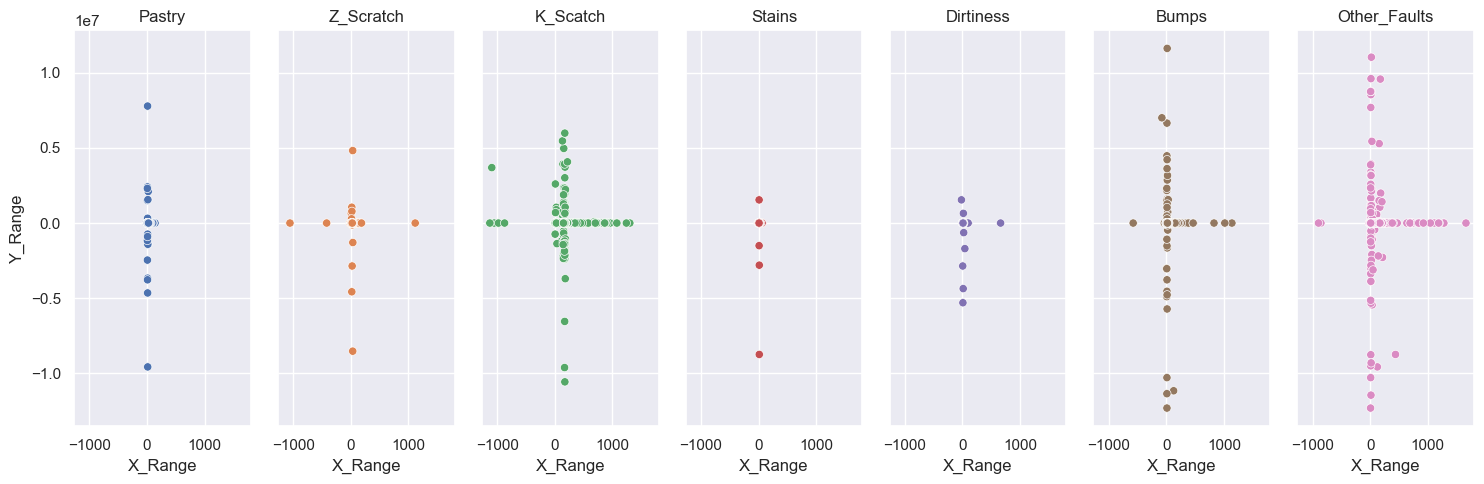

In [13]:
# defect size
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    sns.scatterplot(df_eda[df_eda['defect_type']==defect],
                    x='X_Range', y='Y_Range', hue='defect_type',
                    ax=axs[i]#, s=10, alpha=.5
                    )
    axs[i].get_legend().remove()
    axs[i].set_title(defect)
fig.tight_layout()
fig.show()

- `K_Scratch` has higher `X_Range` than `Z_Scratch`.
- Not sure why there is negative value, the definition of `X_Minimum` and `X_Maximum` are not clear.

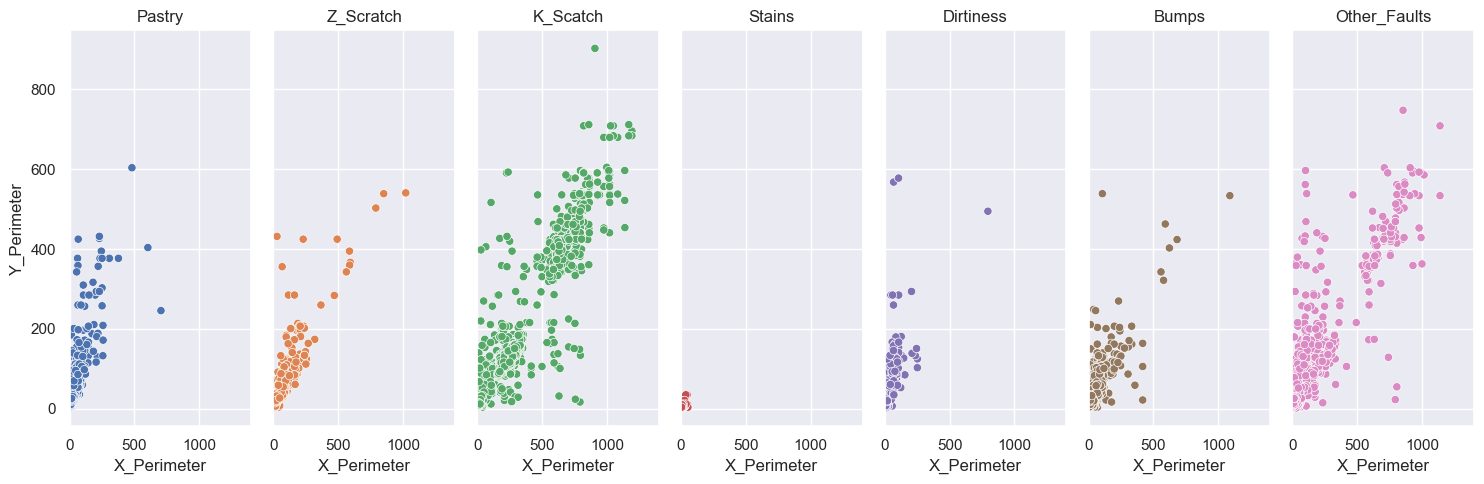

In [14]:
fig, axs = plt.subplots(1, 7, sharey=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    df_temp = df_eda[df_eda['defect_type']==defect]
    sns.scatterplot(df_temp,
                    x='X_Perimeter', y='Y_Perimeter', hue='defect_type',
                    ax=axs[i]#, s=10, alpha=.5
                    )
    axs[i].get_legend().remove()
    axs[i].set_title(defect)
    axs[i].set_xlim(0, 1400)
fig.tight_layout()
fig.show()

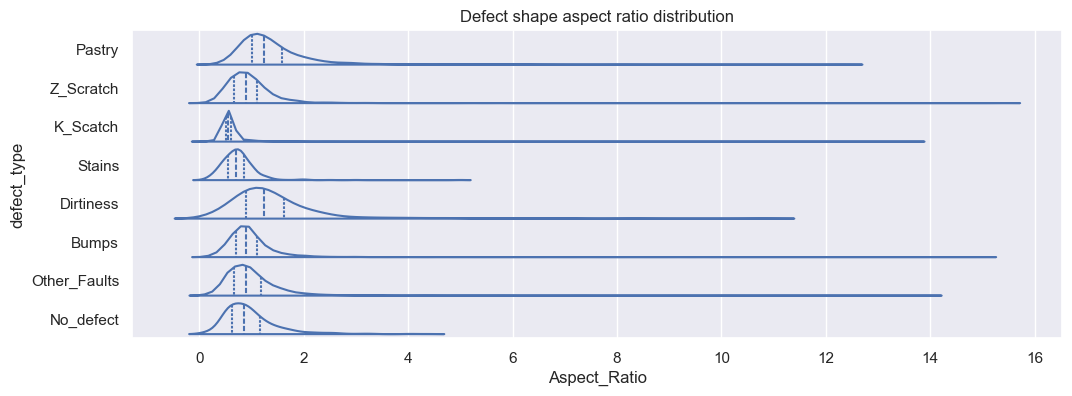

In [15]:
plt.figure(figsize=(12,4))
sns.violinplot(df_eda, y='defect_type', x='Aspect_Ratio', inner='quart', 
               fill=False, split=True, density_norm='width')
plt.title('Defect shape aspect ratio distribution')
plt.show()

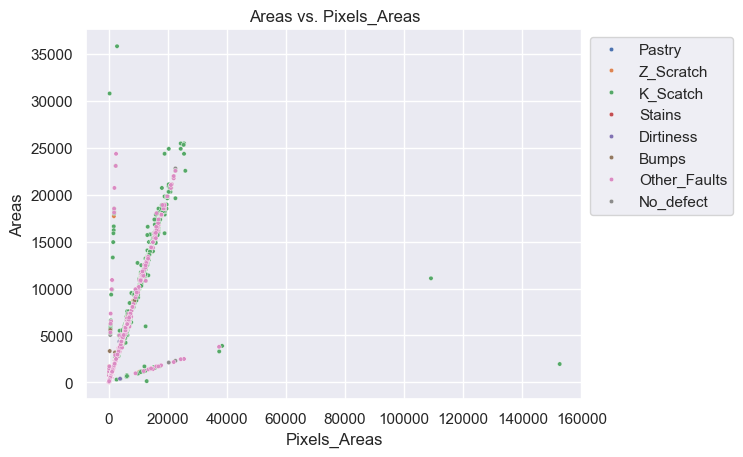

In [16]:
sns.scatterplot(df_eda, x='Pixels_Areas', y=10**df_eda['LogOfAreas'], hue='defect_type', s=10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Areas vs. Pixels_Areas')
plt.ylabel('Areas')
plt.show()

- Looks like this measurement equipment has different spatial resolution setting.
- We can add in this feature as resolution may affect sensitivity to different defect types.
    - `Pixels_Areas` feature may be better dropped.

In [17]:
df_eda['Log_Pixel_Resolution'] = ((10**df_eda['LogOfAreas']) / df_eda['Pixels_Areas']).apply(np.log10)
df_eda.drop(columns=['Pixels_Areas'], inplace=True)

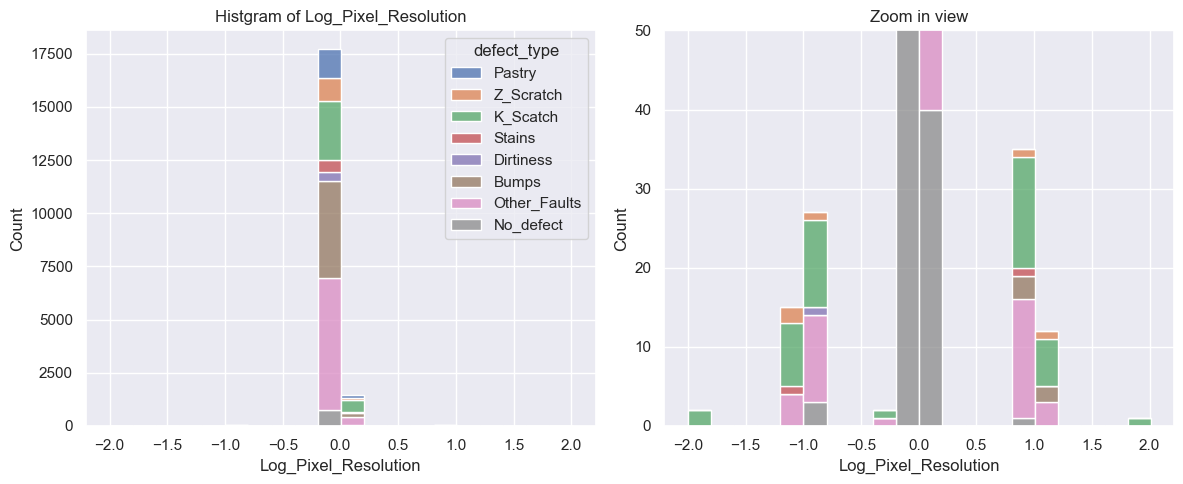

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_eda, x='Log_Pixel_Resolution', binwidth=.2, 
             hue='defect_type', multiple='stack', ax=axs[0])
sns.histplot(df_eda, x='Log_Pixel_Resolution', binwidth=.2, 
             hue='defect_type', multiple='stack', ax=axs[1])
axs[0].set_title('Histgram of Log_Pixel_Resolution')
axs[1].set_title('Zoom in view')
axs[1].set_ylim(0, 50)
axs[1].get_legend().remove()
fig.tight_layout()
fig.show()

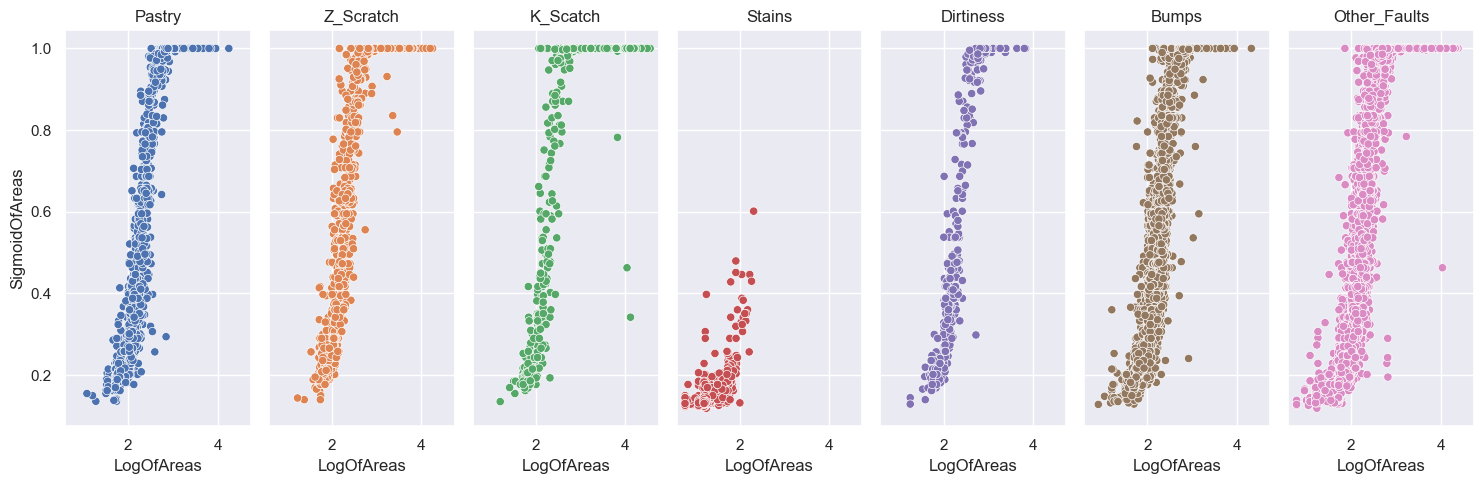

In [19]:
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    sns.scatterplot(df_eda[df_eda['defect_type']==defect],
                    x=df_eda['LogOfAreas'], y='SigmoidOfAreas', hue='defect_type',
                    ax=axs[i]#, s=10, alpha=.5
                    )
    axs[i].get_legend().remove()
    axs[i].set_title(defect)
fig.tight_layout()
fig.show()

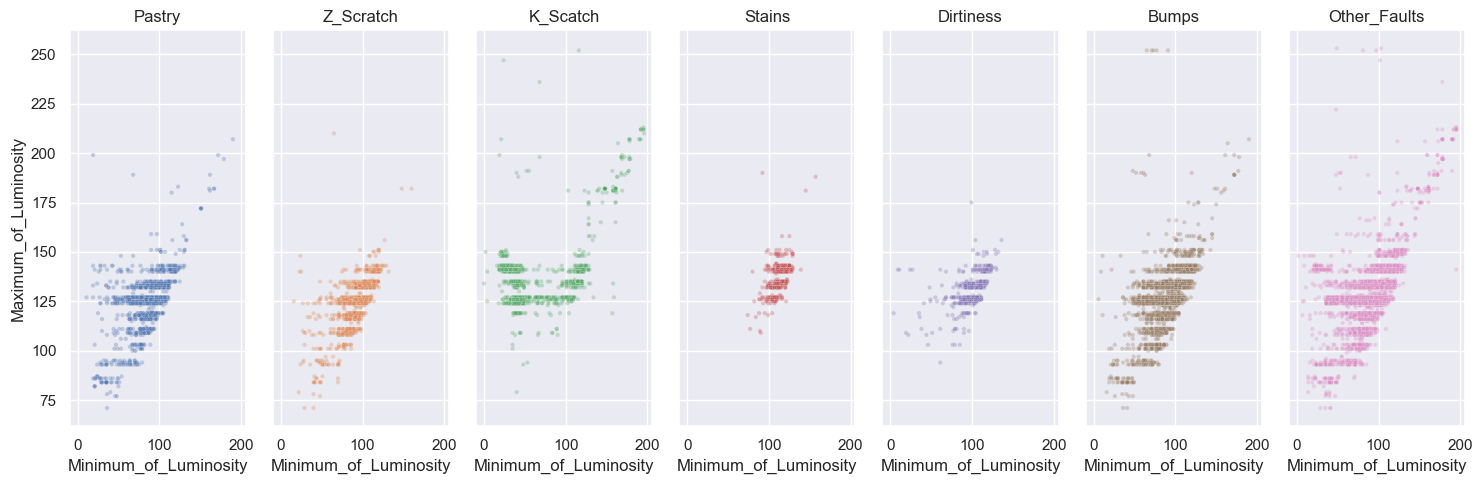

In [20]:
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    sns.scatterplot(df_eda[df_eda['defect_type']==defect],
                    x='Minimum_of_Luminosity', y='Maximum_of_Luminosity', hue='defect_type',
                    ax=axs[i], s=10, alpha=.3
                    )
    axs[i].get_legend().remove()
    axs[i].set_title(defect)
fig.tight_layout()
fig.show()

- `Maximum_of_Luminosity` shows band structure.
    - Maybe due to resolution of the sensor.

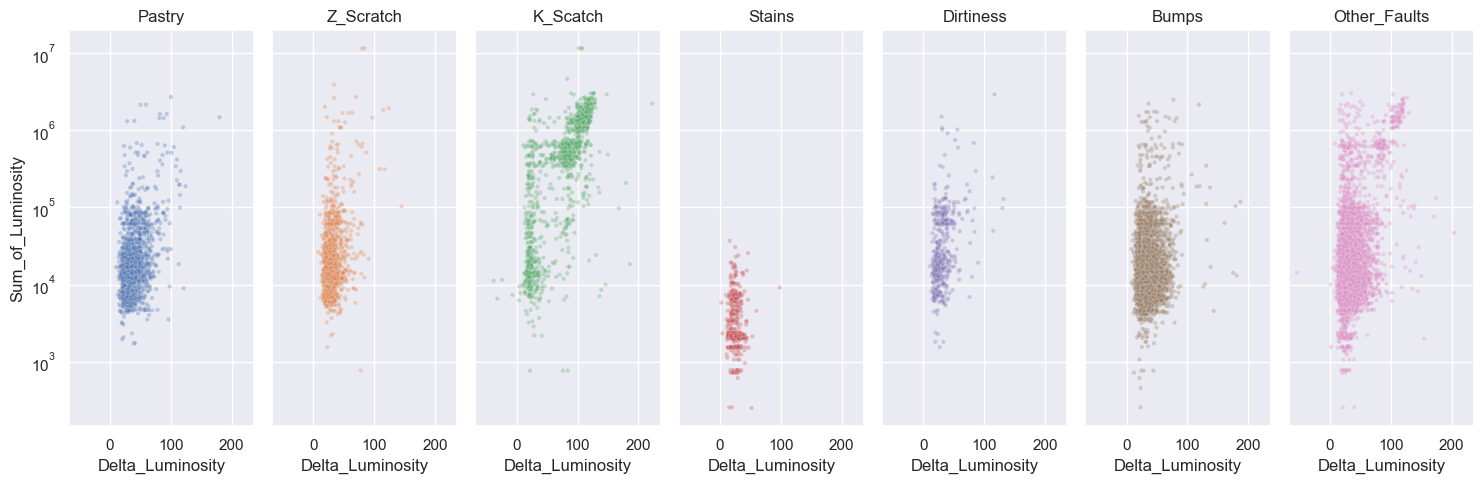

In [21]:
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    sns.scatterplot(df_eda[df_eda['defect_type']==defect],
                    x='Delta_Luminosity', y='Sum_of_Luminosity', hue='defect_type',
                    ax=axs[i], s=10, alpha=.3
                    )
    axs[i].get_legend().remove()
    axs[i].set_title(defect)
plt.yscale('log')
fig.tight_layout()
fig.show()

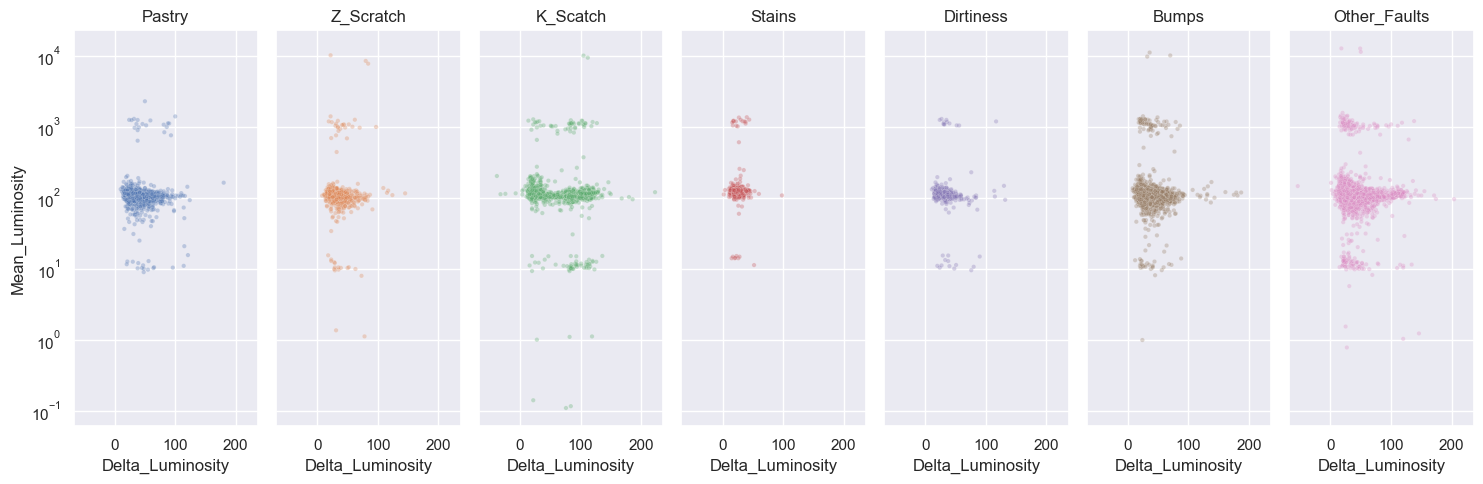

In [22]:
fig, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    sns.scatterplot(df_eda[df_eda['defect_type']==defect],
                    x='Delta_Luminosity', y='Mean_Luminosity', hue='defect_type',
                    ax=axs[i], s=10, alpha=.3
                    )
    axs[i].get_legend().remove()
    axs[i].set_title(defect)
plt.yscale('log')
fig.tight_layout()
fig.show()

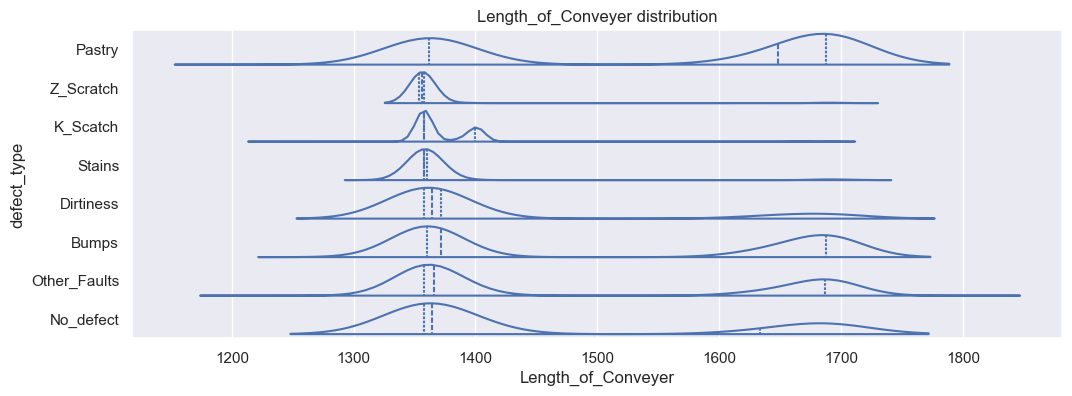

In [23]:
plt.figure(figsize=(12,4))
sns.violinplot(df_eda, y='defect_type', x='Length_of_Conveyer', inner='quart', 
               fill=False, split=True, density_norm='width')
plt.title('Length_of_Conveyer distribution')
plt.show()

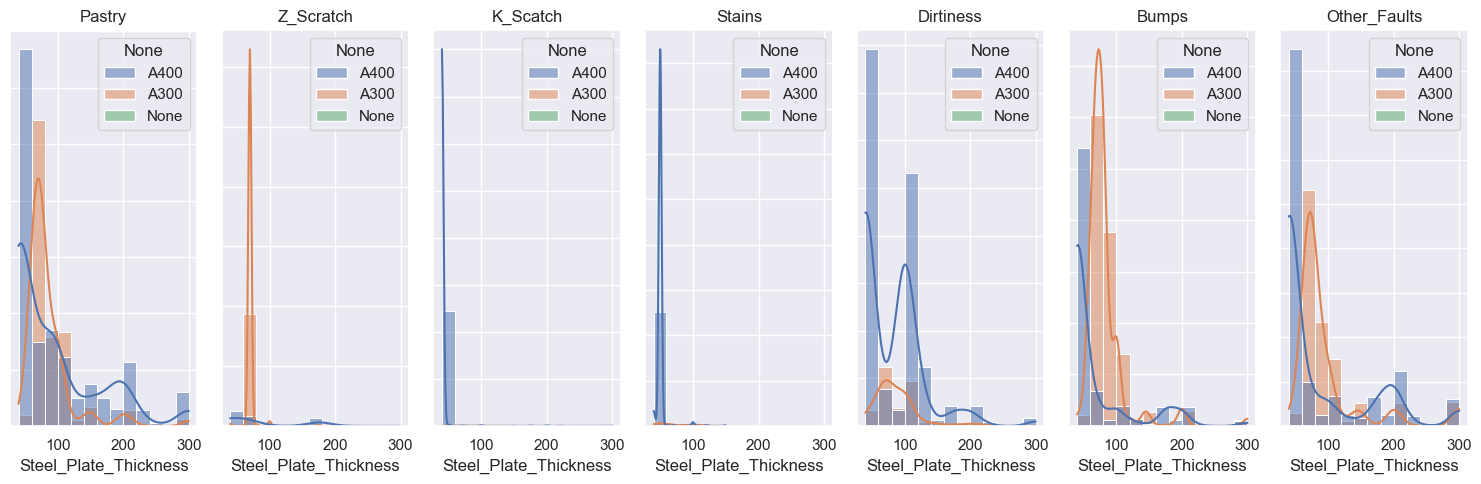

In [24]:
def get_steel(x):
    if x['TypeOfSteel_A300'] == 1: return 'A300'
    if x['TypeOfSteel_A400'] == 1: return 'A400'
    return 'None'

fig, axs = plt.subplots(1, 7, sharex=True, figsize = (15, 5))
for i in range(7):
    defect = pred_features[i]
    sns.histplot(df_eda[df_eda['defect_type']==defect],
                 x='Steel_Plate_Thickness', ax=axs[i],
                 binwidth=20, stat='density', #multiple='stack',
                 hue=df_eda.apply(get_steel, axis=1), kde=True)
    axs[i].set_title(defect)
    axs[i].yaxis.set_ticklabels([])
    axs[i].set_ylabel(None)
fig.tight_layout()
fig.show()

- Clearly steel type and plate thickness show strong prediction power.

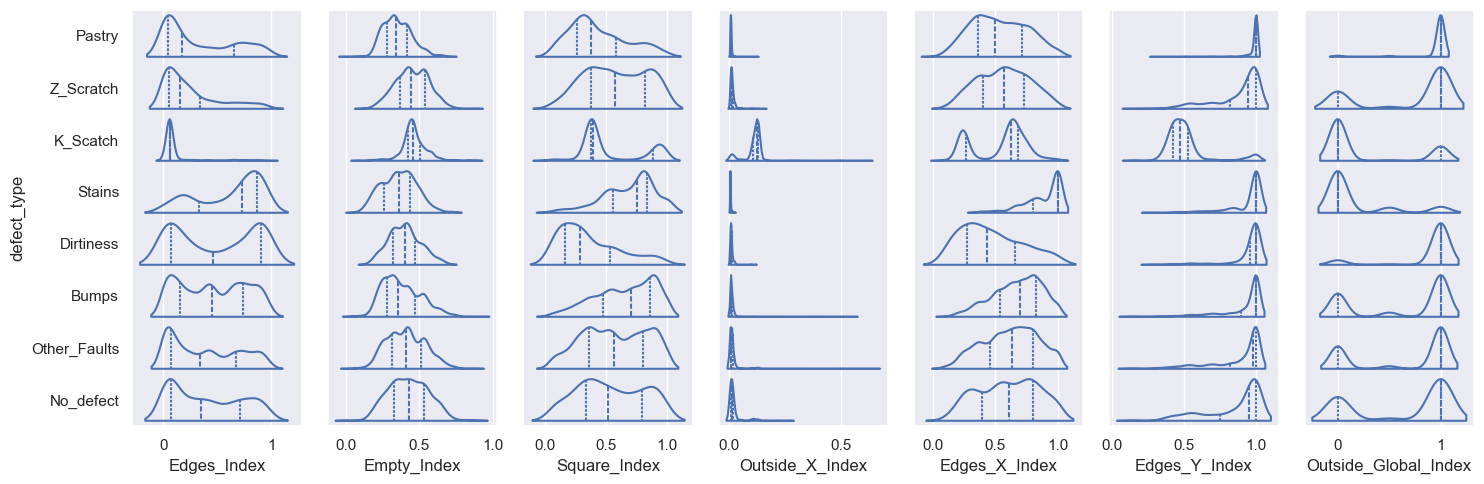

In [25]:
fig, axs = plt.subplots(1, 7, sharey=True, figsize = (15, 5))
features = ['Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 
            'Edges_X_Index','Edges_Y_Index', 'Outside_Global_Index']
for i in range(7):
    feature = features[i]
    sns.violinplot(df_eda, y='defect_type', x=feature, inner='quart', 
                   fill=False, split=True, density_norm='width', ax=axs[i])
    # axs[i].set_title(feature)
# plt.yscale('log')
fig.tight_layout()
fig.show()

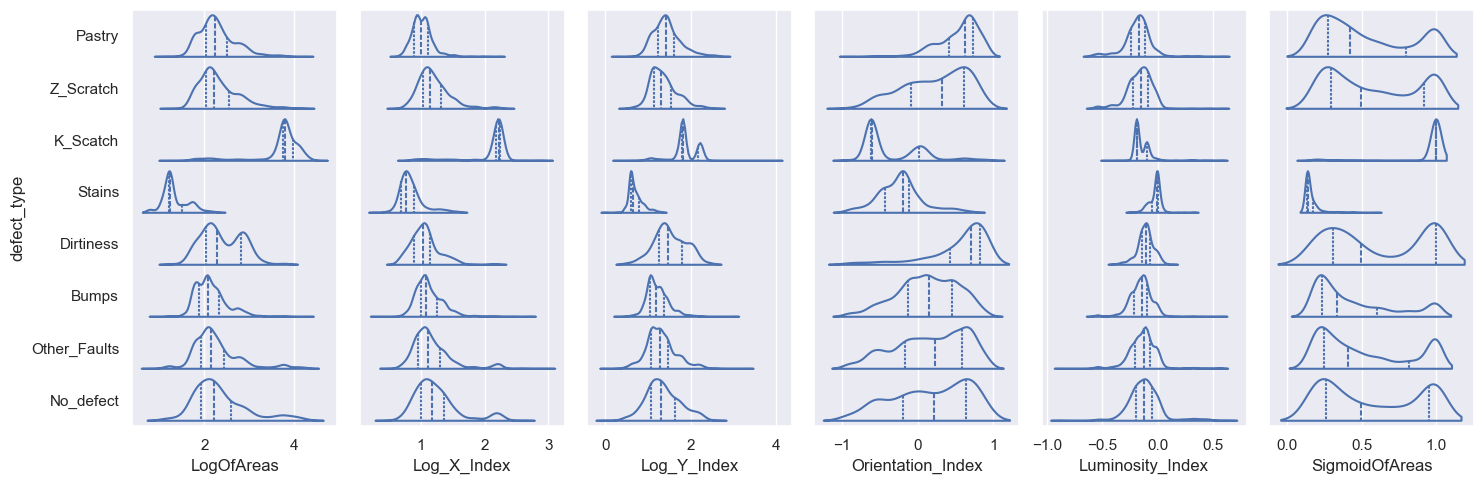

In [26]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize = (15, 5))
features = ['LogOfAreas', 'Log_X_Index', 'Log_Y_Index',
            'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']
for i in range(6):
    feature = features[i]
    sns.violinplot(df_eda, y='defect_type', x=feature, inner='quart', 
                   fill=False, split=True, density_norm='width', ax=axs[i])
    # axs[i].set_title(feature)
# plt.yscale('log')
fig.tight_layout()
fig.show()

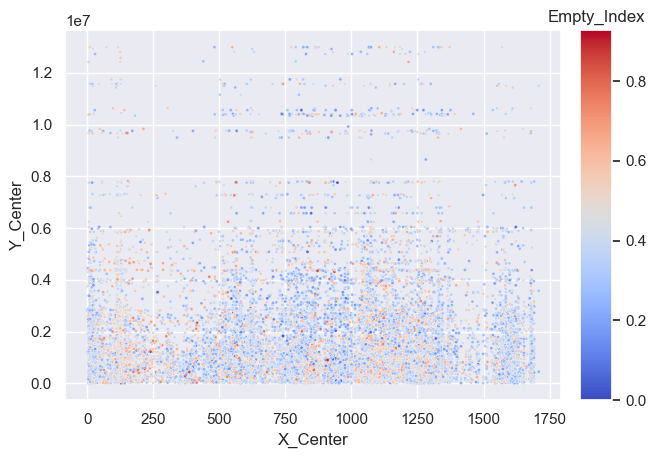

In [27]:
fig, ax = plt.subplots()
sns.scatterplot(df_eda, x='X_Center', y='Y_Center', 
                hue='Empty_Index', palette='coolwarm',
                s=5, ax=ax)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

norm = plt.Normalize(df_eda['Empty_Index'].min(), df_eda['Empty_Index'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
cax = fig.add_axes([ax.get_position().x1+0.03, ax.get_position().y0, 0.05, ax.get_position().height / 1])
ax.figure.colorbar(sm, cax=cax)

# ax.set_title('Defect location')
cax.set_title('Empty_Index')
plt.show()

- `Empty_Index` is related to local defect density.